In [97]:
import numpy
import matplotlib

INCHES_PER_PT = 1.0 / 72.27
COLUMN_WIDTH_PT = 240.0
FONT_SIZE_PT = 8.0

pgf_with_latex = {
    "pgf.texsystem": "pdflatex",
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": [],
    "font.sans-serif": [],
    "font.monospace": [],
    "axes.labelsize": FONT_SIZE_PT,
    "font.size": FONT_SIZE_PT,
    "legend.fontsize": FONT_SIZE_PT,
    "xtick.labelsize": FONT_SIZE_PT,
    "ytick.labelsize": FONT_SIZE_PT,
    "axes.titlesize": FONT_SIZE_PT,
    "figure.figsize": (COLUMN_WIDTH_PT * INCHES_PER_PT, 0.8 * COLUMN_WIDTH_PT * INCHES_PER_PT),
    "pgf.preamble": [
        r"\usepackage[utf8x]{inputenc}",
        r"\usepackage[T1]{fontenc}",
    ]
}
matplotlib.rcParams.update(pgf_with_latex)
print('Figure size:', (COLUMN_WIDTH_PT * INCHES_PER_PT, 0.8 * COLUMN_WIDTH_PT * INCHES_PER_PT))

field = 'cdfs'

Figure size: (3.3208800332088004, 2.6567040265670405)


In [98]:
import collections
import copy
import itertools
import logging
import re

import astropy.io.ascii
import matplotlib.pyplot as plt
%matplotlib inline
import numpy
import scipy.spatial

import pipeline

log = logging.getLogger(__name__)

titlemap = {
    'RGZ & Norris & compact': 'Compact',
    'RGZ & Norris & resolved': 'Resolved',
    'RGZ & Norris': 'All',
    'RGZ & compact': 'Compact',
    'RGZ & resolved': 'Resolved',
    'RGZ': 'All',
}

fullmap = {
    'RGZ & Norris & compact': 'RGZ & compact',
    'RGZ & Norris & resolved': 'RGZ & resolved',
    'RGZ & Norris': 'RGZ',
}

whatset = {
    'RGZ & Norris & compact': 'RGZ & Norris & compact',
    'RGZ & Norris & resolved': 'RGZ & Norris & resolved',
    'RGZ & Norris': 'RGZ & Norris',
    'RGZ & compact': 'RGZ & Norris & compact',
    'RGZ & resolved': 'RGZ & Norris & resolved',
    'RGZ': 'RGZ & Norris',
}

norris_labelled_sets = [
    'RGZ & Norris & compact',
    'RGZ & Norris & resolved',
    'RGZ & Norris',
]

log.debug('Getting SWIRE, ATLAS features.')
swire_names, swire_coords, _ = pipeline.generate_swire_features(overwrite=False, field=field)
swire_labels = pipeline.generate_swire_labels(swire_names, swire_coords, overwrite=False, field=field)
(_, atlas_test_sets), (_, swire_test_sets) = pipeline.generate_data_sets(swire_coords, swire_labels, overwrite=False, field=field)
log.debug('Calling cross-identify.')
cids = list(pipeline.cross_identify_all(swire_names, swire_coords, swire_labels, swire_test_sets, swire_labels[:, 0], field=field))

# Also load the nearest-neighbour cross-identifications.
cids += [pipeline.CrossIdentifications.from_hdf5(
    pipeline.WORKING_DIR + 'NearestNeighbour_{}_cross_ids_{}_RGZ & Norris.h5'.format(field, q)) for q in range(4 if field == 'cdfs' else 1)]

swire_tree = scipy.spatial.KDTree(swire_coords[swire_test_sets[:, 0, 0]])

failed_coords = []

if field == 'cdfs':
    table = astropy.io.ascii.read(pipeline.TABLE_PATH)
    rgzcat = astropy.io.ascii.read(pipeline.RGZ_PATH)

    atlas_to_swire_expert = {}
    atlas_to_swire_rgz = {}
    key_to_atlas = {}
    atlas_id_to_name = {}
    is_compact = {}
    for row in table:
        name = row['Component Name (Franzen)']
        key_to_atlas[row['Key']] = name
        swire = row['Source SWIRE (Norris)']
        if not swire or not swire.startswith('SWIRE') or not name:
            continue
        atlas_id_to_name[row['Component ID (Franzen)']] = name
        atlas_to_swire_expert[name] = swire
        is_compact[name] = pipeline.compact_test(row)
    for row in rgzcat:
        swire_name = row['SWIRE.designation']
        if not swire_name or swire_name == '-99':
            continue
        name = atlas_id_to_name.get(row['atlas_id'], None)
        atlas_to_swire_rgz[name] = swire_name
else:
    atlas_to_swire_expert = {}
    with astropy.io.fits.open(pipeline.MIDDELBERG_TABLE4_PATH) as elais_components_fits:
        elais_components = elais_components_fits[1].data
        atlas_cid_to_name = {}
        atlas_names = []  # Indices correspond to table 4 rows.
        atlas_name_to_compact = {}
        for component in elais_components:
            cid = component['CID']
            name = component['ATELAIS']
            atlas_names.append(name)
            atlas_cid_to_name[cid] = name
            row = {'Component S (Franzen)': component['Sint'],  # Fitting in with the CDFS API...
                   'Component S_ERR (Franzen)': component['e_Sint'],
                   'Component Sp (Franzen)': component['Sp'],
                   'Component Sp_ERR (Franzen)': component['e_Sp']}
            atlas_name_to_compact[name] = pipeline.compact_test(row)
    with open(pipeline.MIDDELBERG_TABLE5_PATH) as elais_file:
        # Took this code from pipeline.py, probably should make it a function
        lines = [line.split('|') for line in elais_file]
        for line in lines:
            if 'ATELAISJ' not in line[0]:
                continue

            line_cids = line[1]
            if 'C0' not in line_cids and 'C1' not in line_cids:
                continue

            line_cids = [cid.strip() for cid in line_cids.split(',')]
            swire_coord_re = re.search(r'SWIRE4J(\d\d)(\d\d)(\d\d\.\d\d)(-\d\d)(\d\d)(\d\d\.\d)', line[2])
            if not swire_coord_re:
                continue
            swire_coord_list = swire_coord_re.groups()
            coord = astropy.coordinates.SkyCoord(
                ra='{} {} {}'.format(*swire_coord_list[:3]),
                dec='{} {} {}'.format(*swire_coord_list[3:]),
                unit=('hourangle', 'deg'))
            coord = (coord.ra.deg, coord.dec.deg)
            # Nearest SWIRE...
            dist, nearest = swire_tree.query(coord)
            if dist > 5 / 60 / 60:
                logging.debug('No SWIRE match found for Middelberg cross-identification {}'.format(line[0]))
                logging.debug('Nearest is {} ({:.01f} arcsec)'.format(numpy.array(swire_names)[swire_test_sets[:, 0, 0]][nearest], dist * 60 * 60))
                logging.debug('Middelberg: {}'.format(swire_coord_re.group()))
                failed_coords.append(coord)
                continue
            name = numpy.array(swire_names)[swire_test_sets[:, 0, 0]][nearest]
            for cid in line_cids:
                atlas_to_swire_expert[atlas_cid_to_name[cid]] = name

labeller_classifier_to_accuracies = collections.defaultdict(list)

# Augment the CIDs by duplicating the "resolved" cross-ids to make the "all" set.
resolved_cids_copy = [copy.copy(cid) for cid in cids if 'resolved' in cid.dataset_name]
for cid in resolved_cids_copy:
    cid.dataset_name = cid.dataset_name.replace(' & resolved', '')
cids.extend(resolved_cids_copy)

for cid in cids:
    if cid.labeller == 'norris' and 'Norris' not in cid.dataset_name:
        continue

    if cid.classifier in {'Groundtruth', 'Random', 'NearestNeighbour'}:
        # Deal with these later as they are special.
        continue

    atlas_to_swire_predictor = dict(zip(cid.radio_names, cid.ir_names))
    n_total = 0
    n_correct = 0
    n_skipped = 0
    n_compact = 0
    if field == 'cdfs':
        atlas_keys = atlas_test_sets[:, pipeline.SET_NAMES[whatset[cid.dataset_name]], cid.quadrant].nonzero()[0]
        # For each ATLAS object in RGZ & Norris...
        for i in atlas_keys:
            name = key_to_atlas[i]
            if name not in atlas_to_swire_expert:
                n_skipped += 1
                continue
            if name not in atlas_to_swire_predictor:
                n_skipped += 1
                continue
            swire_norris = atlas_to_swire_expert[name]
            swire_predictor = atlas_to_swire_predictor[name]
            n_correct += swire_norris == swire_predictor
            n_total += 1
    else:
        # Only one test set for ELAIS.
        atlas_indices = atlas_test_sets[:, 0, 0].nonzero()[0]
        assert atlas_test_sets.shape[0] == len(atlas_names)
        for index in atlas_indices:
            # Screen resolved here.
            atlas_name = atlas_names[index]
            if atlas_name not in atlas_to_swire_expert:
                n_skipped += 1
                continue
            if atlas_name not in atlas_to_swire_predictor:
                n_skipped += 1
                continue
            if 'resolved' in cid.dataset_name and atlas_name_to_compact[atlas_name]:
                n_compact += 1
                continue
            if 'compact' in cid.dataset_name and not atlas_name_to_compact[atlas_name]:
                n_compact += 1
                continue
            swire_middelberg = atlas_to_swire_expert[atlas_name]
            swire_predictor = atlas_to_swire_predictor[atlas_name]
            n_correct += swire_middelberg == swire_predictor
            n_total += 1
        # print('Compact: {:.02%}'.format(n_compact / (n_total + n_compact)))
    if 'Norris' in cid.dataset_name and cid.labeller == 'rgz':
        labeller = 'RGZ N'
    elif cid.labeller == 'rgz':
        labeller = 'RGZ'
    else:
        labeller = 'Norris'
    labeller_classifier_to_accuracies[labeller, cid.classifier, titlemap[cid.dataset_name]].append(n_correct / n_total)

# Groundtruth, random, and NN classifiers exist only for the RGZ & Norris set, but we want to test on all subsets.
# This section duplicates the classifiers and evaluates them on all subsets.
for cid in cids:
    if cid.classifier not in {'Groundtruth', 'Random', 'NearestNeighbour'}:
        continue

    for dataset_name in ['RGZ & Norris', 'RGZ & Norris & resolved', 'RGZ & Norris & compact']:
        atlas_to_swire_predictor = dict(zip(cid.radio_names, cid.ir_names))
        n_total = 0
        n_correct = 0
        n_skipped = 0
        if field == 'cdfs':
            # For each ATLAS object in RGZ & Norris...
            atlas_keys = atlas_test_sets[:, pipeline.SET_NAMES[dataset_name], cid.quadrant].nonzero()[0]
            for i in atlas_keys:
                name = key_to_atlas[i]
                if name not in atlas_to_swire_expert:
                    n_skipped += 1
                    continue
                if name not in atlas_to_swire_predictor:
                    n_skipped += 1
                    continue
                swire_norris = atlas_to_swire_expert[name]
                swire_predictor = atlas_to_swire_predictor[name]
                n_correct += swire_norris == swire_predictor
                if cid.classifier == 'NearestNeighbour' and swire_norris != swire_predictor:
                    pass
                n_total += 1
        else:
            atlas_indices = atlas_test_sets[:, 0, 0].nonzero()[0]
            assert atlas_test_sets.shape[0] == len(atlas_names)
            for index in atlas_indices:
                # Screen resolved here (because the test sets aren't useful for that for ELAIS)
                atlas_name = atlas_names[index]
                if 'resolved' in dataset_name and atlas_name_to_compact[atlas_name]:
                    continue
                if atlas_name not in atlas_to_swire_expert:
                    n_skipped += 1
                    continue
                if atlas_name not in atlas_to_swire_predictor:
                    n_skipped += 1
                    continue
                swire_middelberg = atlas_to_swire_expert[atlas_name]
                swire_predictor = atlas_to_swire_predictor[atlas_name]
                n_correct += swire_middelberg == swire_predictor
                n_total += 1

        if 'Norris' in cid.dataset_name and cid.labeller == 'rgz':
            labeller = 'RGZ N'
        elif cid.labeller == 'rgz':
            labeller = 'RGZ'
        else:
            labeller = 'Norris'
        print(labeller, cid.classifier, titlemap[dataset_name], n_correct, n_total, n_correct / n_total)
        labeller_classifier_to_accuracies[labeller, cid.classifier, titlemap[dataset_name]].append(n_correct / n_total)

if field == 'cdfs':
    # Compute accuracy for RGZ.
    for dataset_name in pipeline.SET_NAMES:
        if '& Norris' not in dataset_name:
            continue
        for quadrant in range(4):
            n_total = 0
            n_correct = 0
            n_skipped = 0
            n_compact = 0
            atlas_keys = atlas_test_sets[:, pipeline.SET_NAMES[whatset[dataset_name]], quadrant].nonzero()[0]
            # For each ATLAS object in RGZ & Norris...
            for i in atlas_keys:
                name = key_to_atlas[i]
                if name not in atlas_to_swire_expert:
                    n_skipped += 1
                    continue
                if name not in atlas_to_swire_rgz:
                    n_skipped += 1
                    continue
                swire_predictor = atlas_to_swire_rgz[name]
                swire_norris = atlas_to_swire_expert[name]
                n_correct += swire_norris == swire_predictor
                n_total += 1
            labeller_classifier_to_accuracies['RGZ', 'Label', titlemap[dataset_name]].append(n_correct / n_total)

labeller_classifier_to_accuracy = {}
labeller_classifier_to_stdev = {}
for key, accuracies in labeller_classifier_to_accuracies.items():
    print('Best {}:'.format(key), max(accuracies))
    labeller_classifier_to_accuracy[key] = numpy.mean(accuracies)
    labeller_classifier_to_stdev[key] = numpy.std(accuracies)

random_acc = {k[2]: v * 100
              for k, v in labeller_classifier_to_accuracy.items()
              if k[1] == 'Random'}
random_stdev = {k[2]: v * 100
                for k, v in labeller_classifier_to_stdev.items()
                if k[1] == 'Random'}
best_acc = {k[2]: v * 100
            for k, v in labeller_classifier_to_accuracy.items()
            if k[1] == 'Groundtruth'}
best_stdev = {k[2]: v * 100
              for k, v in labeller_classifier_to_stdev.items()
              if k[1] == 'Groundtruth'}

Norris Groundtruth All 147 148 0.9932432432432432
Norris Groundtruth Resolved 23 24 0.9583333333333334
Norris Groundtruth Compact 124 124 1.0
Norris Groundtruth All 119 119 1.0
Norris Groundtruth Resolved 21 21 1.0
Norris Groundtruth Compact 98 98 1.0
Norris Groundtruth All 83 85 0.9764705882352941
Norris Groundtruth Resolved 24 24 1.0
Norris Groundtruth Compact 59 61 0.9672131147540983
Norris Groundtruth All 108 113 0.9557522123893806
Norris Groundtruth Resolved 18 18 1.0
Norris Groundtruth Compact 90 95 0.9473684210526315
Norris Random All 131 148 0.8851351351351351
Norris Random Resolved 7 24 0.2916666666666667
Norris Random Compact 124 124 1.0
Norris Random All 104 119 0.8739495798319328
Norris Random Resolved 6 21 0.2857142857142857
Norris Random Compact 98 98 1.0
Norris Random All 63 85 0.7411764705882353
Norris Random Resolved 4 24 0.16666666666666666
Norris Random Compact 59 61 0.9672131147540983
Norris Random All 92 113 0.8141592920353983
Norris Random Resolved 2 18 0.11111111

In [99]:
lr_predictions = itertools.chain(
    pipeline.unserialise_predictions(
        pipeline.WORKING_DIR + 'LogisticRegression_norris_{}_predictions'.format(field)),
    pipeline.unserialise_predictions(
        pipeline.WORKING_DIR + 'LogisticRegression_rgz_{}_predictions'.format(field)))
rf_predictions = itertools.chain(
    pipeline.unserialise_predictions(
        pipeline.WORKING_DIR + 'RandomForestClassifier_norris_{}_predictions'.format(field)),
    pipeline.unserialise_predictions(
        pipeline.WORKING_DIR + 'RandomForestClassifier_rgz_{}_predictions'.format(field)))
cnn_predictions = itertools.chain(
    pipeline.unserialise_predictions(
        pipeline.WORKING_DIR + 'CNN_norris_{}_predictions'.format(field)),
    pipeline.unserialise_predictions(
        pipeline.WORKING_DIR + 'CNN_rgz_{}_predictions'.format(field)))

# Convert to the format we need. e.g. {'RGZ' -> [acc, acc, acc, acc]}
_norris_accuracies = {}
_rgz_accuracies = {}
_norris_accuracies['lr'] = {sstr: [0] * 4 for sstr in pipeline.SET_NAMES}
_rgz_accuracies['lr'] = {sstr: [0] * 4 for sstr in pipeline.SET_NAMES}
_norris_accuracies['rf'] = {sstr: [0] * 4 for sstr in pipeline.SET_NAMES}
_rgz_accuracies['rf'] = {sstr: [0] * 4 for sstr in pipeline.SET_NAMES}
_norris_accuracies['cnn'] = {sstr: [0] * 4 for sstr in pipeline.SET_NAMES}
_rgz_accuracies['cnn'] = {sstr: [0] * 4 for sstr in pipeline.SET_NAMES}
for predictions in lr_predictions:
    dataset_name = predictions.dataset_name
    if predictions.labeller == 'norris':
        _norris_accuracies['lr'][dataset_name][predictions.quadrant] = predictions.balanced_accuracy
    else:
        _rgz_accuracies['lr'][dataset_name][predictions.quadrant] = predictions.balanced_accuracy
for predictions in rf_predictions:
    dataset_name = predictions.dataset_name
    if predictions.labeller == 'norris':
        _norris_accuracies['rf'][dataset_name][predictions.quadrant] = predictions.balanced_accuracy
    else:
        _rgz_accuracies['rf'][dataset_name][predictions.quadrant] = predictions.balanced_accuracy
for predictions in cnn_predictions:
    dataset_name = predictions.dataset_name
    print(dataset_name, predictions.balanced_accuracy)
    if predictions.labeller == 'norris':
        _norris_accuracies['cnn'][dataset_name][predictions.quadrant] = predictions.balanced_accuracy
    else:
        _rgz_accuracies['cnn'][dataset_name][predictions.quadrant] = predictions.balanced_accuracy

RGZ 0.5
RGZ & Norris 0.924038341451
RGZ & Norris & compact 0.92759226302
RGZ & Norris & resolved 0.907981297615
RGZ & compact 0.343406940802
RGZ & resolved 0.577751498689
RGZ 0.500042434015
RGZ & Norris 0.917148891167
RGZ & Norris & compact 0.929257927
RGZ & Norris & resolved 0.914105393037
RGZ & compact 0.5
RGZ & resolved 0.613012227525
RGZ 0.5
RGZ & Norris 0.912341057635
RGZ & Norris & compact 0.914202317291
RGZ & Norris & resolved 0.905288175876
RGZ & compact 0.626500297089
RGZ & resolved 0.327066250743
RGZ 0.5
RGZ & Norris 0.92835702272
RGZ & Norris & compact 0.932661183408
RGZ & Norris & resolved 0.91912404316
RGZ & compact 0.5
RGZ & resolved 0.498354291501
RGZ 0.881020513301
RGZ & Norris 0.892844932559
RGZ & Norris & compact 0.897134148245
RGZ & Norris & resolved 0.899157768203
RGZ & compact 0.874219042713
RGZ & resolved 0.890885709379
RGZ 0.866255165525
RGZ & Norris 0.88624158664
RGZ & Norris & compact 0.887669001626
RGZ & Norris & resolved 0.874614666501
RGZ & compact 0.8700471

In [100]:
bas = {'Norris': _norris_accuracies, 'RGZ': _rgz_accuracies}
nnn = {'LogisticRegression': 'lr', 'RandomForestClassifier': 'rf', 'CNN': 'cnn'}

In [101]:
bas['Norris']

{'cnn': {'RGZ': [0.5, 0.50004243401510651, 0.5, 0.5],
  'RGZ & Norris': [0.92403834145123021,
   0.91714889116654374,
   0.91234105763517537,
   0.92835702271961551],
  'RGZ & Norris & compact': [0.92759226301985764,
   0.92925792700043741,
   0.91420231729055257,
   0.93266118340828119],
  'RGZ & Norris & resolved': [0.90798129761458723,
   0.91410539303690452,
   0.90528817587641108,
   0.91912404315989327],
  'RGZ & compact': [0.3434069408017984, 0.5, 0.62650029708853239, 0.5],
  'RGZ & resolved': [0.57775149868864739,
   0.61301222752466067,
   0.32706625074272133,
   0.49835429150139254]},
 'lr': {'RGZ': [0.9618966217060072,
   0.95768512655128968,
   0.93037878787878792,
   0.96222479321488308],
  'RGZ & Norris': [0.93433245909828899,
   0.93116745768023024,
   0.91169934640522876,
   0.94474233846771338],
  'RGZ & Norris & compact': [0.91565466154614716,
   0.92459377590923042,
   0.89899732620320849,
   0.92263940676079514],
  'RGZ & Norris & resolved': [0.94670522667665791,
  

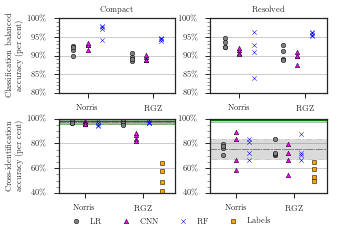

In [102]:
fig, ((compact_ba, resolved_ba), (compact_xid, resolved_xid)) = plt.subplots(
    2, 2, figsize=(COLUMN_WIDTH_PT * INCHES_PER_PT * 1.6, COLUMN_WIDTH_PT * INCHES_PER_PT))


markers = {'LogisticRegression': 'o', 'CNN': '^', 'RandomForestClassifier': 'x'}
colours = {'LogisticRegression': 'grey', 'CNN': 'magenta', 'RandomForestClassifier': 'blue'}

handles = {}

linewidth = 1
size = 20
marker_linewidth = 0.5

for l, labeller in enumerate(['Norris', 'RGZ']):
    if labeller == 'RGZ' and field == 'cdfs':
        # Labels
        accs = labeller_classifier_to_accuracies[labeller, 'Label', 'Resolved']
        resolved_xid.scatter([l * 4 + c + 1] * 4, accs,
                             c='orange', marker='s', zorder=2,
                             linewidth=marker_linewidth, edgecolor='k', s=size)
        accs = labeller_classifier_to_accuracies[labeller, 'Label', 'Compact']
        handles[3] = compact_xid.scatter([l * 4 + c + 1] * 4, accs,
                                                 c='orange', marker='s', zorder=2,
                                                 linewidth=marker_linewidth, edgecolor='k', s=size)

    for c, classifier in enumerate(['LogisticRegression', 'CNN', 'RandomForestClassifier']):
        accs = labeller_classifier_to_accuracies[labeller, classifier, 'Compact']
        handles[c] = compact_xid.scatter([l * 4 + c] * 4, accs,
                                         c=colours[classifier], marker=markers[classifier], zorder=2,
                                         linewidth=marker_linewidth, edgecolor='k', s=size)
        accs = labeller_classifier_to_accuracies[labeller, classifier, 'Resolved']
        resolved_xid.scatter([l * 4 + c] * 4, accs,
                             c=colours[classifier], marker=markers[classifier], zorder=2,
                             linewidth=marker_linewidth, edgecolor='k', s=size)
        compact_ba.scatter([l * 4 + c] * 4, bas[labeller][nnn[classifier]]['RGZ & Norris & compact'],
                           c=colours[classifier], marker=markers[classifier],
                           linewidth=marker_linewidth, edgecolor='k', s=size)
        resolved_ba.scatter([l * 4 + c] * 4, bas[labeller][nnn[classifier]]['RGZ & Norris & resolved'],
                            c=colours[classifier], marker=markers[classifier],
                            linewidth=marker_linewidth, edgecolor='k', s=size)

        if field == 'cdfs':
            xlim = 8
            rgz_tick = 5.5
        else:
            xlim = 7
            rgz_tick = 5
    
        nn_accs = labeller_classifier_to_accuracies['Norris', 'NearestNeighbour', 'Compact']
        compact_xid.fill_between([-1, 10], [numpy.mean(nn_accs) - numpy.std(nn_accs)] * 2,
                                 [numpy.mean(nn_accs) + numpy.std(nn_accs)] * 2, color='grey', alpha=0.05,
                                 edgecolor='grey', linestyle='-.', linewidth=linewidth)
        compact_xid.axhline(numpy.mean(nn_accs), color='grey', linestyle='-.', zorder=1, linewidth=linewidth)
        nn_accs = labeller_classifier_to_accuracies['Norris', 'NearestNeighbour', 'Resolved']
        resolved_xid.fill_between([-1, 10], [numpy.mean(nn_accs) - numpy.std(nn_accs)] * 2,
                                 [numpy.mean(nn_accs) + numpy.std(nn_accs)] * 2, color='grey', alpha=0.05,
                                  edgecolor='grey', linestyle='-.', linewidth=linewidth)
        resolved_xid.axhline(numpy.mean(nn_accs), color='grey', linestyle='-.', zorder=1, linewidth=linewidth)

        nn_accs = labeller_classifier_to_accuracies['Norris', 'Groundtruth', 'Resolved']
        resolved_xid.fill_between([-1, 10], [numpy.mean(nn_accs) - numpy.std(nn_accs)] * 2,
                                 [numpy.mean(nn_accs) + numpy.std(nn_accs)] * 2, color='green', alpha=0.05,
                                  edgecolor='green', linewidth=linewidth)
        resolved_xid.axhline(numpy.mean(nn_accs), color='green', zorder=1, linewidth=linewidth)
        nn_accs = labeller_classifier_to_accuracies['Norris', 'Groundtruth', 'Compact']
        compact_xid.fill_between([-1, 10], [numpy.mean(nn_accs) - numpy.std(nn_accs)] * 2,
                                 [numpy.mean(nn_accs) + numpy.std(nn_accs)] * 2, color='green', alpha=0.05,
                                  edgecolor='green', linewidth=linewidth)
        compact_xid.axhline(numpy.mean(nn_accs), color='green', zorder=1, linewidth=linewidth)
        nn_accs = labeller_classifier_to_accuracies['Norris', 'Random', 'Resolved']
        resolved_xid.fill_between([-1, 10], [numpy.mean(nn_accs) - numpy.std(nn_accs)] * 2,
                                 [numpy.mean(nn_accs) + numpy.std(nn_accs)] * 2, color='blue', alpha=0.05,
                                  edgecolor='blue', linestyle='-.', linewidth=linewidth)
        resolved_xid.axhline(numpy.mean(nn_accs), color='blue', linestyle='-.', linewidth=linewidth, zorder=1)
        resolved_xid.set_xlim((-1, xlim))
        compact_xid.set_xlim((-1, xlim))
        resolved_ba.set_xlim((-1, 7))
        compact_ba.set_xlim((-1, 7))
        
        
        if c == 2 and l == 0 and field == 'elais':
            acc = numpy.mean(bas[labeller][nnn[classifier]]['RGZ & Norris & resolved'])
            resolved_ba.annotate('{:.1%}'.format(acc), (l * 4 + c, 0.825), ha='center', va='bottom')
            resolved_ba.arrow(2, 0.825, 0, -0.015, head_width=0.25, head_length=0.01, ec='k', fc='k')

compact_ba.set_ylabel('Classification balanced\naccuracy (per cent)')
# resolved_ba.set_ylabel('Balanced accuracy (per cent)')
resolved_xid.yaxis.set_label_position('right')
compact_xid.set_ylabel('Cross-identification\naccuracy (per cent)')
resolved_ba.yaxis.set_label_position('right')
# resolved_xid.set_ylabel('Accuracy (per cent)')
compact_ba.grid(axis='y')
compact_ba.set_ylim((0.80, 1.0))
resolved_ba.grid(axis='y')
resolved_ba.set_ylim((0.80, 1.0))
compact_xid.grid(axis='y')
compact_xid.set_ylim((0.40, 1.0))
resolved_xid.grid(axis='y')
resolved_xid.set_ylim((0.40, 1.0))
compact_ba.set_title('Compact')
resolved_ba.set_title('Resolved')
compact_ba.set_yticks(numpy.arange(0.8, 1.01, 0.05))
resolved_ba.set_yticks(numpy.arange(0.8, 1.01, 0.05))

# Change all these to percentages.
for ax in [compact_ba, resolved_ba, compact_xid, resolved_xid]:
    vals = ax.get_yticks()
    ax.set_yticklabels(['{:3.0f}\%'.format(x*100) for x in vals])
    ax.set_xticks([1, rgz_tick])
    ax.set_xticklabels(['Norris', 'RGZ'])
    ax.tick_params(axis='both', which='major', direction='out', length=5)
    ax.tick_params(axis='y', which='minor', direction='out', length=3)
    ax.minorticks_on()

if field == 'cdfs':
    plt.figlegend([handles[j] for j in sorted(handles)], ['LR', 'CNN', 'RF', 'Labels'],
                  'lower center', ncol=4)
else:
    plt.figlegend([handles[j] for j in sorted(handles)], ['LR', 'CNN', 'RF'],
                  'lower center', ncol=3)
plt.subplots_adjust(bottom=0.15, hspace=0.35, wspace=0.3, left=0.2)

plt.savefig('/Users/alger/repos/crowdastro-projects/ATLAS-CDFS/images/{}-grid-new.pdf'.format(field))

In [103]:
handles

{0: <matplotlib.collections.PathCollection at 0x1175739b0>,
 1: <matplotlib.collections.PathCollection at 0x1172b6f98>,
 2: <matplotlib.collections.PathCollection at 0x119df04e0>,
 3: <matplotlib.collections.PathCollection at 0x116b65f28>}

In [104]:
accs = {'Compact': {}, 'Resolved': {}, 'All': {}}
stdevs = {'Compact': {}, 'Resolved': {}, 'All': {}}

for labeller in ['Norris', 'RGZ']:
    for classifier in ['Label', 'Groundtruth', 'LogisticRegression', 'CNN', 'RandomForestClassifier', 'NearestNeighbour', 'Random']:
        for ds in ['Compact', 'Resolved', 'All']:
            try:
                acc = labeller_classifier_to_accuracy[labeller, classifier, ds]
                accs[ds][labeller, classifier] = acc
                stdev = labeller_classifier_to_stdev[labeller, classifier, ds]
                stdevs[ds][labeller, classifier] = stdev
            except KeyError:
                continue

In [105]:
ba_accs = {'Compact': {}, 'Resolved': {}, 'All': {}}
ba_stdevs = {'Compact': {}, 'Resolved': {}, 'All': {}}
for labeller in ['Norris', 'RGZ']:
    for classifier in ['LogisticRegression', 'CNN', 'RandomForestClassifier']:
        for ds in ['RGZ & Norris & compact', 'RGZ & Norris & resolved', 'RGZ & Norris']:
            try:
                acc = numpy.mean(bas[labeller][nnn[classifier]][ds])
                ba_accs[titlemap[ds]][labeller, classifier] = acc
                stdev = numpy.std(bas[labeller][nnn[classifier]][ds])
                ba_stdevs[titlemap[ds]][labeller, classifier] = stdev
            except KeyError:
                continue
                
bas['Norris'][nnn['LogisticRegression']]

{'RGZ': [0.9618966217060072,
  0.95768512655128968,
  0.93037878787878792,
  0.96222479321488308],
 'RGZ & Norris': [0.93433245909828899,
  0.93116745768023024,
  0.91169934640522876,
  0.94474233846771338],
 'RGZ & Norris & compact': [0.91565466154614716,
  0.92459377590923042,
  0.89899732620320849,
  0.92263940676079514],
 'RGZ & Norris & resolved': [0.94670522667665791,
  0.93518334758681021,
  0.92233957219251339,
  0.92425986312011443],
 'RGZ & compact': [0.94958981203946546,
  0.94726529093413592,
  0.92709150326797385,
  0.94189416296800355],
 'RGZ & resolved': [0.94070188584988135,
  0.94044516546001733,
  0.92537730243612604,
  0.93734944242611928]}

In [106]:
print('\\hline')
print('Labeller & Classifier & Mean `Compact\' accuracy & Mean `Resolved\' accuracy & Mean `All\' accuracy\\\\')
print(' &  & (per cent) & (per cent) & (per cent)\\\\')
print('\\hline')
for labeller in ['Norris', 'RGZ']:
    for classifier in ['Label', 'Groundtruth', 'LogisticRegression', 'CNN', 'RandomForestClassifier', 'NearestNeighbour', 'Random']:
        try:
            print('{} & {} & ${:.1f} \\pm {:.1f}$ & ${:.1f} \\pm {:.1f}$ & ${:.1f} \\pm {:.1f}$\\\\'.format(
                labeller, classifier,
                100 * accs['Compact'][labeller, classifier], 100 * stdevs['Compact'][labeller, classifier],
                100 * accs['Resolved'][labeller, classifier], 100 * stdevs['Resolved'][labeller, classifier],
                100 * accs['All'][labeller, classifier], 100 * stdevs['All'][labeller, classifier]))
        except KeyError:
            continue
print('\\hline')

\hline
Labeller & Classifier & Mean `Compact' accuracy & Mean `Resolved' accuracy & Mean `All' accuracy\\
 &  & (per cent) & (per cent) & (per cent)\\
\hline
Norris & Groundtruth & $97.9 \pm 2.2$ & $99.0 \pm 1.8$ & $98.1 \pm 1.7$\\
Norris & LogisticRegression & $97.3 \pm 0.5$ & $76.0 \pm 3.2$ & $93.7 \pm 1.8$\\
Norris & CNN & $96.6 \pm 0.9$ & $74.3 \pm 12.3$ & $93.5 \pm 0.5$\\
Norris & RandomForestClassifier & $96.1 \pm 1.4$ & $75.8 \pm 6.7$ & $93.8 \pm 2.0$\\
Norris & NearestNeighbour & $97.2 \pm 1.7$ & $75.7 \pm 7.9$ & $93.4 \pm 0.8$\\
Norris & Random & $97.9 \pm 2.2$ & $22.3 \pm 9.2$ & $83.2 \pm 4.7$\\
RGZ & Label & $53.1 \pm 8.5$ & $56.7 \pm 5.9$ & $54.4 \pm 5.9$\\
RGZ & LogisticRegression & $97.3 \pm 1.9$ & $74.5 \pm 5.1$ & $93.6 \pm 1.7$\\
RGZ & CNN & $85.4 \pm 2.6$ & $68.1 \pm 9.2$ & $92.4 \pm 1.1$\\
RGZ & RandomForestClassifier & $97.5 \pm 0.9$ & $74.3 \pm 7.9$ & $93.7 \pm 1.5$\\
\hline


In [107]:
labeller_classifier_to_accuracies

defaultdict(list,
            {('Norris', 'CNN', 'All'): [0.9324324324324325,
              0.9411764705882353,
              0.9294117647058824,
              0.9380530973451328,
              0.9324324324324325,
              0.9411764705882353,
              0.9294117647058824,
              0.9380530973451328],
             ('Norris', 'CNN', 'Compact'): [0.96,
              0.9797979797979798,
              0.9672131147540983,
              0.9578947368421052],
             ('Norris', 'CNN', 'Resolved'): [0.5833333333333334,
              0.6666666666666666,
              0.8333333333333334,
              0.8888888888888888],
             ('Norris', 'Groundtruth', 'All'): [0.9932432432432432,
              1.0,
              0.9764705882352941,
              0.9557522123893806],
             ('Norris', 'Groundtruth', 'Compact'): [1.0,
              1.0,
              0.9672131147540983,
              0.9473684210526315],
             ('Norris', 'Groundtruth', 'Resolved'): [0.958333

In [108]:
for i in pipeline.unserialise_predictions(
        pipeline.WORKING_DIR + 'CNN_norris_{}_predictions'.format(field)):
    print(i.dataset_name)

RGZ
RGZ & Norris
RGZ & Norris & compact
RGZ & Norris & resolved
RGZ & compact
RGZ & resolved
RGZ
RGZ & Norris
RGZ & Norris & compact
RGZ & Norris & resolved
RGZ & compact
RGZ & resolved
RGZ
RGZ & Norris
RGZ & Norris & compact
RGZ & Norris & resolved
RGZ & compact
RGZ & resolved
RGZ
RGZ & Norris
RGZ & Norris & compact
RGZ & Norris & resolved
RGZ & compact
RGZ & resolved


In [109]:
ba_accs['Resolved']['Norris', 'RandomForestClassifier']

0.90974687541063415

In [110]:
print('\\hline')
print('Labeller & Classifier & Mean `Compact\' accuracy & Mean `Resolved\' accuracy & Mean `All\' accuracy\\\\')
print(' &  & (per cent) & (per cent) & (per cent)\\\\')
print('\\hline')
for labeller in ['Norris', 'RGZ']:
    for classifier in ['Label', 'Groundtruth', 'LogisticRegression', 'CNN', 'RandomForestClassifier', 'NearestNeighbour', 'Random']:
        try:
            print('{} & {} & ${:.1f} \\pm {:.1f}$ & ${:.1f} \\pm {:.1f}$ & ${:.1f} \\pm {:.1f}$\\\\'.format(
                labeller, classifier,
                100 * ba_accs['Compact'][labeller, classifier], 100 * ba_stdevs['Compact'][labeller, classifier],
                100 * ba_accs['Resolved'][labeller, classifier], 100 * ba_stdevs['Resolved'][labeller, classifier],
                100 * ba_accs['All'][labeller, classifier], 100 * ba_stdevs['All'][labeller, classifier]))
        except KeyError:
            continue
print('\\hline')

\hline
Labeller & Classifier & Mean `Compact' accuracy & Mean `Resolved' accuracy & Mean `All' accuracy\\
 &  & (per cent) & (per cent) & (per cent)\\
\hline
Norris & LogisticRegression & $91.5 \pm 1.0$ & $93.2 \pm 1.0$ & $93.0 \pm 1.2$\\
Norris & CNN & $92.6 \pm 0.7$ & $91.2 \pm 0.5$ & $92.0 \pm 0.6$\\
Norris & RandomForestClassifier & $96.7 \pm 1.5$ & $91.0 \pm 4.5$ & $96.0 \pm 2.5$\\
RGZ & LogisticRegression & $89.5 \pm 0.8$ & $90.5 \pm 1.7$ & $90.2 \pm 0.8$\\
RGZ & CNN & $89.4 \pm 0.6$ & $89.6 \pm 1.3$ & $89.4 \pm 0.5$\\
RGZ & RandomForestClassifier & $94.5 \pm 0.2$ & $95.8 \pm 0.4$ & $94.7 \pm 0.3$\\
\hline
